### 处理数据

In [9]:
import torch
from torchvision import datasets, transforms

# transforms.Compose将多个数据变换组合成一个序列，以便轻松地对数据进行一系列处理
transform = transforms.Compose([transforms.ToTensor()])

# 下载和加载MNIST数据集
train_dataset = datasets.MNIST(root='./torch_data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./torch_data', train=False, transform=transform, download=True)

# 添加验证集
val_size=500
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [len(train_dataset) - val_size, val_size])

# 创建数据加载器:DataLoader对象会动态加载数据批次
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 定义模型：encoder

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Encoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        # latent_dim是方差和均值的维度
        
        # 卷积特征提取
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
        )
        
        # 计算均值和方差的对数
        self.fc1 = nn.Linear(64*7*7, 400)  # 设计网络的时候需要计算feature map的尺寸是7*7
        self.fc2_mean = nn.Linear(400, latent_dim)
        self.fc2_logvar = nn.Linear(400, latent_dim)
    
    def forward(self, x: torch.Tensor) -> (torch.Tensor, torch.Tensor):
        x = self.feature_extractor(x)

        # 注意：这里定义mean是均值，logvar是对数方差，是要配合后面的采样和损失计算才有意义
        x = F.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar

## 定义模型：decoder

In [11]:
# 注意这里的输入是已经采样好的z,latent_dim也是z的维度。z是encoder的mean和logvar采样得到，因此encoder和decoder的latent_dim必须相同
class Decoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        
        
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 64*7*7),
            nn.ReLU(),
        )
        
        # 转置卷积实现上采样：增大feature map的尺寸，直到原始尺寸28*28
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            # 确保输出在 [0,1]，因为我们输入图片也经过归一化处理，并且损失函数也可以采用二元交叉熵
            nn.Sigmoid(),  
        )
    
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = self.fc(z)

        # reshape尺寸(batch_size, 64, 7, 7)，才能进行转置卷积操作
        z = z.view(z.size(0), 64, 7, 7)

        # 转置卷积上采样
        x_recon = self.decoder(z)
        return x_recon

## 定义模型：连接encoder和decoder，加入reparameterization trick

In [12]:
class VAE(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        
        # Instantiate the Encoder and Decoder
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """采样方法：μ+eps*σ"""
        # 注意logvar是方差的对数，std才是标准差σ
        std = torch.exp(0.5 * logvar)
        # 标准正态分布采样
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x: torch.Tensor) -> tuple:
        # encoder得到均值和方差对数
        mu, logvar = self.encoder(x)
        
        # reparameterization trick
        z = self.reparameterize(mu, logvar)
        
        # 重建图像
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, logvar

## 定义损失函数

In [14]:
# 包括两部分：重建损失和encoder的后验分布与标准正态分布的损失(kl散度或者交叉熵)
def mse_recon_loss(recon_x, x):
    # 重建mse损失：均方差损失
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    return recon_loss

def bce_recon_loss(recon_x, x):
    # 重建bce损失：二元交叉熵损失
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    return recon_loss

# kl散度，标准正态分布在前
def kld_std_first_latent_loss(mu,logvar):
    # KL divergence loss (regularization term)
    latent_loss = 0.5 * torch.sum(logvar - 1 + (mu.pow(2)+1)/logvar.exp())
    return latent_loss

# kl散度，标准正态分布在后
def kld_std_back_latent_loss(mu,logvar):
    # KL divergence loss (regularization term)
    latent_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return latent_loss

# 交叉熵，标准正态分布在前
def ce_std_first_latent_loss(mu,logvar):
    # cross entropy loss (regularization term)
    latent_loss = 0.5 * torch.sum(logvar - 1 + (mu.pow(2)+1)/logvar.exp())
    return latent_loss

# 交叉熵，标准正态分布在后
def ce_std_back_latent_loss(mu,logvar):
    # cross entropy (regularization term)
    latent_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return latent_loss



def additive_loss(recon_loss,latent_loss,batch_size):
    # batch_size = x.size(0)
    return (recon_loss + latent_loss)/batch_size

## 训练

In [23]:
#训练设备
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print('Using {} device'.format(device))
device = torch.device(device)

def train(model,recon_loss_function,latent_loss_function,device=device,num_epochs=100):
    # Adam优化器
    optimizer=torch.optim.Adam(model.parameters(),lr=1.0e-3)
    num_epochs = num_epochs  # 根据需要调整训练周期

    for epoch in range(num_epochs):
        # 切换到训练模式
        model.train()  
        running_train_loss = 0.0
        for images,labels in train_loader:
            optimizer.zero_grad()  # 清零梯度
            images = images.to(device)
            recon_batch, mu, logvar = model(images)  # 输入数据到模型
            recon_loss = recon_loss_function(recon_batch,images)
            latent_loss = latent_loss_function(mu, logvar)
            batch_size = images.size(0)
            loss = additive_loss(recon_loss,latent_loss,batch_size) # 计算损失
            loss.backward()  # 反向传播
            optimizer.step()  # 更新模型参数
            running_train_loss += loss.item()
        train_loss = running_train_loss / len(train_loader) 

        # 在验证集上计算损失
        model.eval()  # 切换到评估模式
        running_val_loss = 0.0
        for images,labels in val_loader:
            images = images.to(device)
            recon_batch, mu, logvar = model(images)
            recon_loss = recon_loss_function(recon_batch,images)
            latent_loss = latent_loss_function(mu, logvar)
            batch_size = images.size(0)
            loss = additive_loss(recon_loss,latent_loss,batch_size) 
            running_val_loss += loss.item()
        val_loss = running_val_loss / len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')
    return model

Using cuda device


### 尝试一个损失函数组合训练:mse_recon_loss和kld_std_first_latent_loss

In [24]:
# 将模型移到GPU（如果可用）
model = VAE(latent_dim=2).to(device)
model = train(model,recon_loss_function=mse_recon_loss,latent_loss_function=kld_std_first_latent_loss)

Epoch [1/100] - Train Loss: 52.4657 - Validation Loss: 46.0237
Epoch [2/100] - Train Loss: 44.7387 - Validation Loss: 44.5503
Epoch [3/100] - Train Loss: 43.8290 - Validation Loss: 43.8539
Epoch [4/100] - Train Loss: 43.3954 - Validation Loss: 43.5073
Epoch [5/100] - Train Loss: 43.0433 - Validation Loss: 43.3150
Epoch [6/100] - Train Loss: 42.8395 - Validation Loss: 43.5562
Epoch [7/100] - Train Loss: 42.6261 - Validation Loss: 42.7096
Epoch [8/100] - Train Loss: 42.5458 - Validation Loss: 42.8528
Epoch [9/100] - Train Loss: 42.3870 - Validation Loss: 42.6022
Epoch [10/100] - Train Loss: 42.2702 - Validation Loss: 42.6020
Epoch [11/100] - Train Loss: 42.2003 - Validation Loss: 42.1010
Epoch [12/100] - Train Loss: 42.1494 - Validation Loss: 42.3957
Epoch [13/100] - Train Loss: 42.0466 - Validation Loss: 42.2097
Epoch [14/100] - Train Loss: 41.9828 - Validation Loss: 42.3271
Epoch [15/100] - Train Loss: 41.9152 - Validation Loss: 41.9053
Epoch [16/100] - Train Loss: 41.9047 - Validation

## 生成随机图像

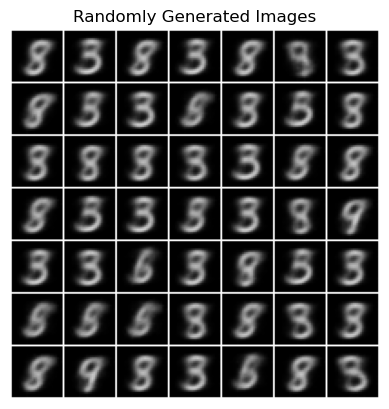

In [26]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def generate_images(model,n=7):
    # 切换到推理模式
    model.eval()
    latent_dim=2

    #Sample from the latent space (the standard normal) and generate images
    num_samples = n**2
    z = torch.randn(num_samples, latent_dim).to(device)

    with torch.no_grad():
        images = model.decoder(z).cpu()


    # Visualize the generated images in a grid
    grid = make_grid(images, nrow=n, padding=1, pad_value=1)
    grid = grid.permute(1, 2, 0)

    plt.imshow(grid)
    plt.axis('off')
    plt.title('Randomly Generated Images')
    plt.show()

generate_images(model)

## 生成随机图像：假如采样过程不是标准正太分布，而是网格探索[-1.5,1.5]之间

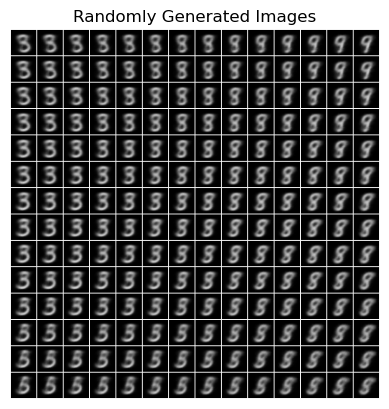

In [27]:
def generate_grid_images(model,Threshold=1.5,step=14):
    # 切换到推理模式
    model.eval()
    latent_dim=2

    # Generate a 2D grid of values in the latent space and generate images
    steps = step
    latent_values = torch.linspace(-Threshold, Threshold, steps)
    grid_z = torch.tensor([[z1, z2] for z1 in latent_values for z2 in latent_values]).to(device)

    with torch.no_grad():
        images = model.decoder(grid_z).cpu()


    # Visualize the generated images in a grid
    grid = make_grid(images, nrow=steps, padding=1, pad_value=1)
    grid = grid.permute(1, 2, 0)

    plt.imshow(grid)
    plt.axis('off')
    plt.title('Randomly Generated Images')
    plt.show()
generate_grid_images(model)

###  尝试一个损失函数组合训练:mse_recon_loss和kld_std_back_latent_loss

Epoch [1/100] - Train Loss: 53.3113 - Validation Loss: 45.8344
Epoch [2/100] - Train Loss: 43.1716 - Validation Loss: 42.5667
Epoch [3/100] - Train Loss: 41.2119 - Validation Loss: 40.9014
Epoch [4/100] - Train Loss: 39.9577 - Validation Loss: 39.5360
Epoch [5/100] - Train Loss: 39.0844 - Validation Loss: 38.9448
Epoch [6/100] - Train Loss: 38.4966 - Validation Loss: 38.7945
Epoch [7/100] - Train Loss: 38.1087 - Validation Loss: 38.1900
Epoch [8/100] - Train Loss: 37.7737 - Validation Loss: 38.0529
Epoch [9/100] - Train Loss: 37.5510 - Validation Loss: 37.8688
Epoch [10/100] - Train Loss: 37.3286 - Validation Loss: 37.5950
Epoch [11/100] - Train Loss: 37.1566 - Validation Loss: 37.2454
Epoch [12/100] - Train Loss: 37.0018 - Validation Loss: 37.5530
Epoch [13/100] - Train Loss: 36.8936 - Validation Loss: 37.1468
Epoch [14/100] - Train Loss: 36.7613 - Validation Loss: 37.0670
Epoch [15/100] - Train Loss: 36.6315 - Validation Loss: 37.0306
Epoch [16/100] - Train Loss: 36.5215 - Validation

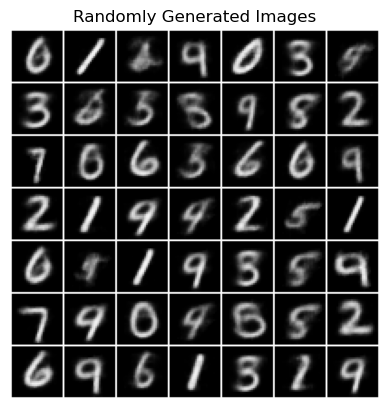

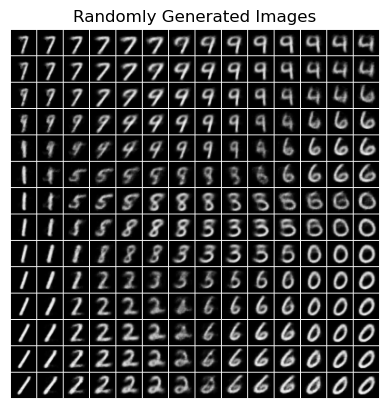

In [28]:
# 将模型移到GPU（如果可用）
model = VAE(latent_dim=2).to(device)
model = train(model,recon_loss_function=mse_recon_loss,latent_loss_function=kld_std_back_latent_loss)

generate_images(model)

generate_grid_images(model)

###  尝试一个损失函数组合训练:mse_recon_loss和ce_std_first_latent_loss

Epoch [1/100] - Train Loss: 54.0648 - Validation Loss: 46.5055
Epoch [2/100] - Train Loss: 44.8075 - Validation Loss: 44.8172
Epoch [3/100] - Train Loss: 44.0079 - Validation Loss: 44.7129
Epoch [4/100] - Train Loss: 43.5982 - Validation Loss: 43.9203
Epoch [5/100] - Train Loss: 43.2761 - Validation Loss: 43.5662
Epoch [6/100] - Train Loss: 43.0010 - Validation Loss: 44.2261
Epoch [7/100] - Train Loss: 42.8761 - Validation Loss: 43.4037
Epoch [8/100] - Train Loss: 42.6612 - Validation Loss: 42.8779
Epoch [9/100] - Train Loss: 42.5913 - Validation Loss: 43.1312
Epoch [10/100] - Train Loss: 42.3920 - Validation Loss: 42.6810
Epoch [11/100] - Train Loss: 42.4241 - Validation Loss: 43.0731
Epoch [12/100] - Train Loss: 42.3210 - Validation Loss: 42.9975
Epoch [13/100] - Train Loss: 42.1840 - Validation Loss: 42.7373
Epoch [14/100] - Train Loss: 42.1301 - Validation Loss: 43.1891
Epoch [15/100] - Train Loss: 42.0769 - Validation Loss: 42.3691
Epoch [16/100] - Train Loss: 42.0162 - Validation

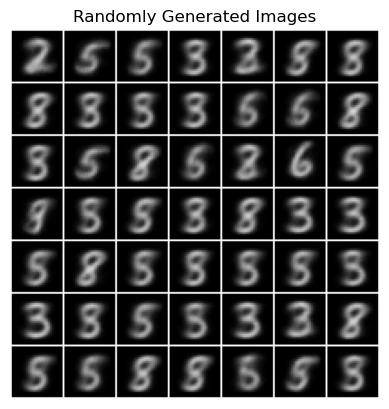

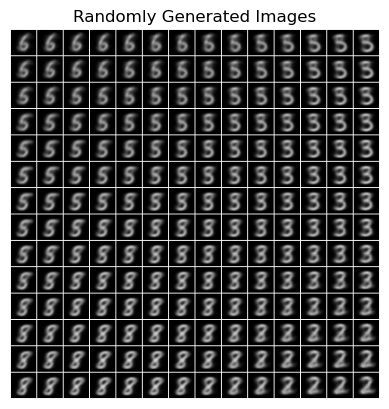

In [29]:
# 将模型移到GPU（如果可用）
model = VAE(latent_dim=2).to(device)
model = train(model,recon_loss_function=mse_recon_loss,latent_loss_function=ce_std_first_latent_loss)

generate_images(model)

generate_grid_images(model)

###  尝试一个损失函数组合训练:mse_recon_loss和ce_std_back_latent_loss

Epoch [1/100] - Train Loss: 51.7975 - Validation Loss: 44.1278
Epoch [2/100] - Train Loss: 42.4656 - Validation Loss: 41.6424
Epoch [3/100] - Train Loss: 41.0336 - Validation Loss: 40.8005
Epoch [4/100] - Train Loss: 40.1303 - Validation Loss: 39.6786
Epoch [5/100] - Train Loss: 39.3538 - Validation Loss: 39.2019
Epoch [6/100] - Train Loss: 38.6870 - Validation Loss: 38.5329
Epoch [7/100] - Train Loss: 38.2164 - Validation Loss: 38.0001
Epoch [8/100] - Train Loss: 37.8139 - Validation Loss: 37.8834
Epoch [9/100] - Train Loss: 37.5211 - Validation Loss: 37.4778
Epoch [10/100] - Train Loss: 37.2902 - Validation Loss: 37.3284
Epoch [11/100] - Train Loss: 37.0699 - Validation Loss: 37.3143
Epoch [12/100] - Train Loss: 36.8715 - Validation Loss: 36.9852
Epoch [13/100] - Train Loss: 36.7357 - Validation Loss: 36.8117
Epoch [14/100] - Train Loss: 36.5999 - Validation Loss: 36.5757
Epoch [15/100] - Train Loss: 36.4757 - Validation Loss: 36.7848
Epoch [16/100] - Train Loss: 36.3740 - Validation

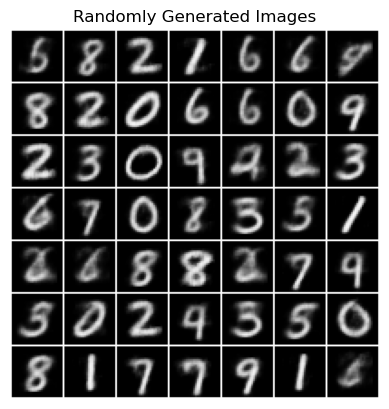

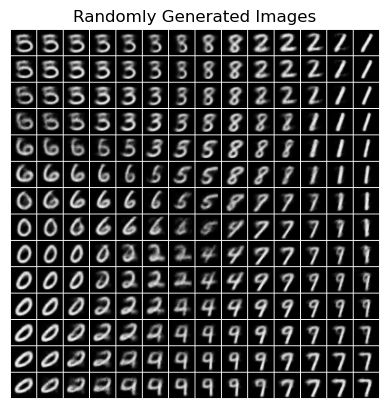

In [30]:
# 将模型移到GPU（如果可用）
model = VAE(latent_dim=2).to(device)
model = train(model,recon_loss_function=mse_recon_loss,latent_loss_function=ce_std_back_latent_loss)

generate_images(model)

generate_grid_images(model)

###  尝试一个损失函数组合训练:bce_recon_loss和kld_std_first_latent_loss

Epoch [1/100] - Train Loss: 209.2172 - Validation Loss: 184.4158
Epoch [2/100] - Train Loss: 175.7660 - Validation Loss: 174.2252
Epoch [3/100] - Train Loss: 170.2450 - Validation Loss: 170.4979
Epoch [4/100] - Train Loss: 167.9008 - Validation Loss: 168.4371
Epoch [5/100] - Train Loss: 166.2703 - Validation Loss: 166.8357
Epoch [6/100] - Train Loss: 164.9837 - Validation Loss: 166.3343
Epoch [7/100] - Train Loss: 163.8068 - Validation Loss: 165.1458
Epoch [8/100] - Train Loss: 163.0624 - Validation Loss: 165.0994
Epoch [9/100] - Train Loss: 162.5580 - Validation Loss: 163.2933
Epoch [10/100] - Train Loss: 161.9628 - Validation Loss: 164.1173
Epoch [11/100] - Train Loss: 161.4885 - Validation Loss: 161.9683
Epoch [12/100] - Train Loss: 161.2162 - Validation Loss: 163.7966
Epoch [13/100] - Train Loss: 160.7248 - Validation Loss: 162.4083
Epoch [14/100] - Train Loss: 160.5102 - Validation Loss: 160.8694
Epoch [15/100] - Train Loss: 160.3797 - Validation Loss: 161.1059
Epoch [16/100] - Tr

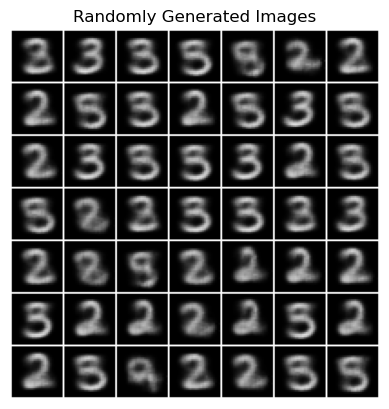

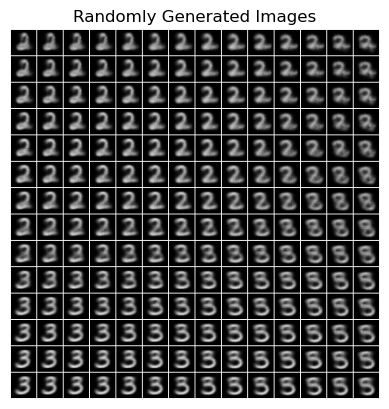

In [31]:
# 将模型移到GPU（如果可用）
model = VAE(latent_dim=2).to(device)
model = train(model,recon_loss_function=bce_recon_loss,latent_loss_function=kld_std_first_latent_loss)

generate_images(model)

generate_grid_images(model)

###  尝试一个损失函数组合训练:bce_recon_loss和kld_std_back_latent_loss

Epoch [1/100] - Train Loss: 196.7454 - Validation Loss: 171.5566
Epoch [2/100] - Train Loss: 165.5075 - Validation Loss: 163.1307
Epoch [3/100] - Train Loss: 160.2931 - Validation Loss: 159.4297
Epoch [4/100] - Train Loss: 157.1307 - Validation Loss: 156.3054
Epoch [5/100] - Train Loss: 154.9243 - Validation Loss: 154.4738
Epoch [6/100] - Train Loss: 153.1687 - Validation Loss: 153.0456
Epoch [7/100] - Train Loss: 151.7639 - Validation Loss: 150.6834
Epoch [8/100] - Train Loss: 150.6718 - Validation Loss: 150.2246
Epoch [9/100] - Train Loss: 149.6908 - Validation Loss: 148.6729
Epoch [10/100] - Train Loss: 148.8983 - Validation Loss: 149.0130
Epoch [11/100] - Train Loss: 148.2254 - Validation Loss: 147.6802
Epoch [12/100] - Train Loss: 147.6557 - Validation Loss: 147.3393
Epoch [13/100] - Train Loss: 147.0465 - Validation Loss: 147.5518
Epoch [14/100] - Train Loss: 146.6528 - Validation Loss: 146.7425
Epoch [15/100] - Train Loss: 146.2567 - Validation Loss: 146.2047
Epoch [16/100] - Tr

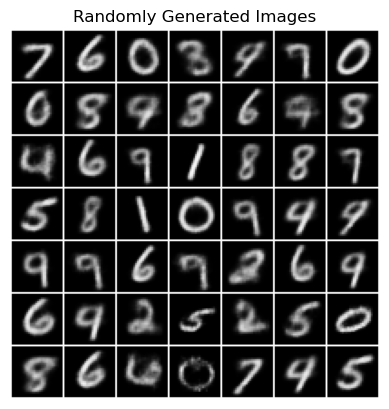

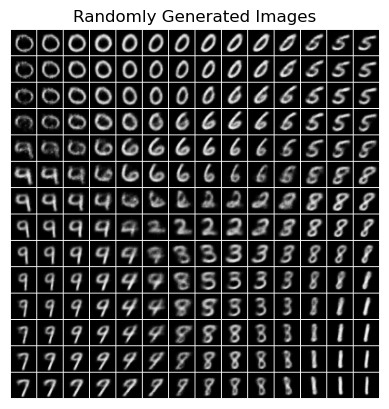

In [32]:
# 将模型移到GPU（如果可用）
model = VAE(latent_dim=2).to(device)
model = train(model,recon_loss_function=bce_recon_loss,latent_loss_function=kld_std_back_latent_loss)

generate_images(model)

generate_grid_images(model)

###  尝试一个损失函数组合训练:bce_recon_loss和ce_std_first_latent_loss

Epoch [1/100] - Train Loss: 196.7893 - Validation Loss: 182.0103
Epoch [2/100] - Train Loss: 174.5528 - Validation Loss: 172.6187
Epoch [3/100] - Train Loss: 169.1575 - Validation Loss: 169.9549
Epoch [4/100] - Train Loss: 167.0110 - Validation Loss: 167.2842
Epoch [5/100] - Train Loss: 165.6380 - Validation Loss: 165.5901
Epoch [6/100] - Train Loss: 164.6007 - Validation Loss: 163.9885
Epoch [7/100] - Train Loss: 163.5933 - Validation Loss: 164.4024
Epoch [8/100] - Train Loss: 162.9676 - Validation Loss: 163.8053
Epoch [9/100] - Train Loss: 162.4179 - Validation Loss: 162.5047
Epoch [10/100] - Train Loss: 162.0455 - Validation Loss: 162.4279
Epoch [11/100] - Train Loss: 161.5872 - Validation Loss: 161.8736
Epoch [12/100] - Train Loss: 161.3227 - Validation Loss: 163.0793
Epoch [13/100] - Train Loss: 160.9818 - Validation Loss: 163.7582
Epoch [14/100] - Train Loss: 160.5426 - Validation Loss: 161.8182
Epoch [15/100] - Train Loss: 160.3307 - Validation Loss: 161.4855
Epoch [16/100] - Tr

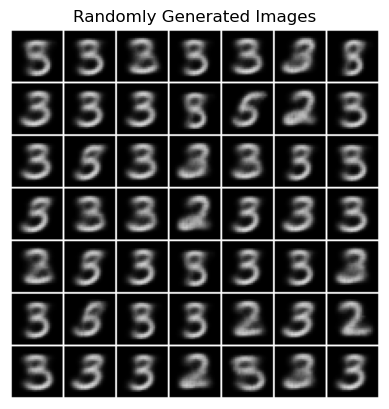

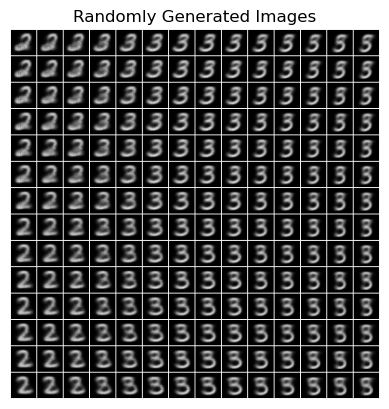

In [33]:
# 将模型移到GPU（如果可用）
model = VAE(latent_dim=2).to(device)
model = train(model,recon_loss_function=bce_recon_loss,latent_loss_function=ce_std_first_latent_loss)

generate_images(model)

generate_grid_images(model)

###  尝试一个损失函数组合训练:bce_recon_loss和ce_std_back_latent_loss

Epoch [1/100] - Train Loss: 190.2297 - Validation Loss: 170.2158
Epoch [2/100] - Train Loss: 164.2766 - Validation Loss: 162.5156
Epoch [3/100] - Train Loss: 158.9330 - Validation Loss: 157.6975
Epoch [4/100] - Train Loss: 155.1911 - Validation Loss: 154.2755
Epoch [5/100] - Train Loss: 152.7592 - Validation Loss: 152.6467
Epoch [6/100] - Train Loss: 151.0368 - Validation Loss: 150.7826
Epoch [7/100] - Train Loss: 149.8273 - Validation Loss: 149.3374
Epoch [8/100] - Train Loss: 148.8500 - Validation Loss: 148.5755
Epoch [9/100] - Train Loss: 148.0319 - Validation Loss: 147.6277
Epoch [10/100] - Train Loss: 147.4037 - Validation Loss: 147.5322
Epoch [11/100] - Train Loss: 146.7992 - Validation Loss: 146.6352
Epoch [12/100] - Train Loss: 146.3856 - Validation Loss: 147.2750
Epoch [13/100] - Train Loss: 145.9006 - Validation Loss: 146.2928
Epoch [14/100] - Train Loss: 145.5492 - Validation Loss: 145.2387
Epoch [15/100] - Train Loss: 145.1276 - Validation Loss: 145.7966
Epoch [16/100] - Tr

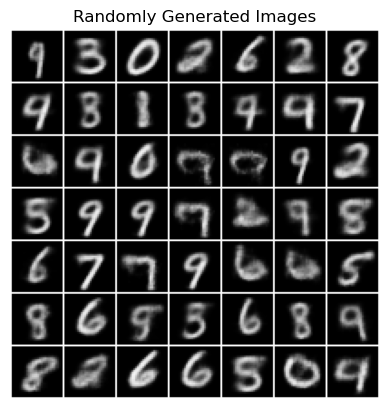

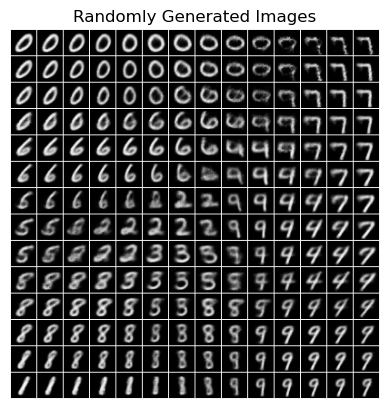

In [34]:
# 将模型移到GPU（如果可用）
model = VAE(latent_dim=2).to(device)
model = train(model,recon_loss_function=bce_recon_loss,latent_loss_function=ce_std_back_latent_loss)

generate_images(model)

generate_grid_images(model)